# (29) Traversal (+Eval)

**Motivation**: Load models, evaluate, do latent traversal. <br>

In [1]:
# HIDE CODE


import os, sys
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-MTMST/_extras')
fig_base_dir = pjoin(git_dir, 'jb-MTMST/figs')
tmp_dir = pjoin(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_MTMST'))
from figures.fighelper import *
from model.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

## Load model

In [2]:
%%time

model_name = 'k-32_z-7x[10,20]_cells-2_pre-1x3_post-1x3'
fit_name = 'Clamp(Sig:5,Mu:25)-BalancerDebugged_ep1000-b512-lr(0.001)_beta(0.25)-anneal(1x0.3)_lambda(0.01)_grad(1000)_bal-equal_(2023_03_27,18:33)'
tr, metadata = load_model(
    model_name=model_name,
    fit_name=fit_name,
    device='cuda:2',
    verbose=True,
)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|     VAE     |  17.0 Mil  |
|     ---     |    ---     |
|     stem    |   1.1 K    |
|     pre     |   96.0 K   |
|  enc_tower  |  9.4 Mil   |
| enc_sampler |  1.4 Mil   |
| dec_sampler |  1.4 Mil   |
|    expand   |   70.8 K   |
|  dec_tower  |  4.5 Mil   |
|     post    |   40.0 K   |
|     out     |    578     |
|  cos_recon  |     0      |
|   l2_recon  |     0      |
|   l1_recon  |     0      |
|  l1_weight  |     0      |
+-------------+------------+

# params: 17.0 M

CPU times: user 42.9 s, sys: 3.81 s, total: 46.7 s
Wall time: 9.58 s


In [3]:
%%time

val, loss = tr.validate(use_ema=False)
val_ema, loss_ema = tr.validate(use_ema=True)

CPU times: user 4min 1s, sys: 1.41 s, total: 4min 3s
Wall time: 3min 54s


In [5]:
loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(loss_summary)

{
    'kl': {'vae': 38.24, 'ema': 38.24},
    'epe': {'vae': 2.45, 'ema': 2.45},
    'cos': {'vae': 4.76, 'ema': 4.75},
    'l1': {'vae': 0.69, 'ema': 0.68},
    'l2': {'vae': 0.33, 'ema': 0.33}
}

fig/sample (VAE)

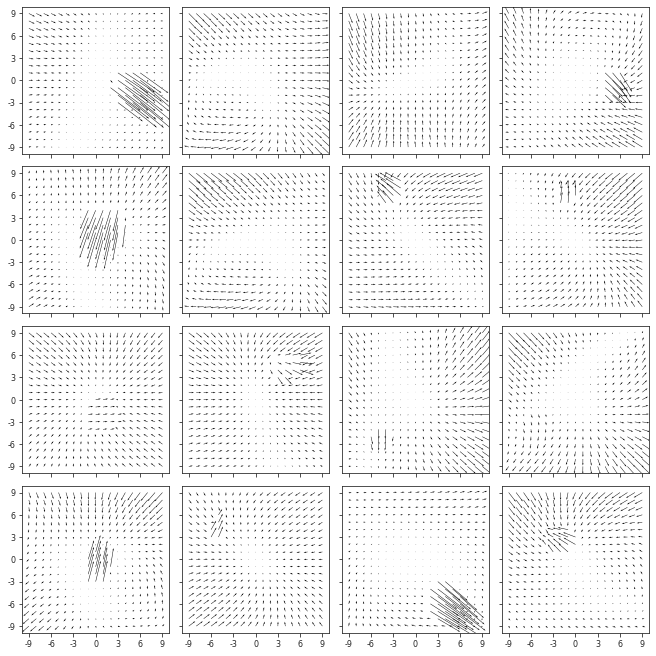

fig/sample (EMA)

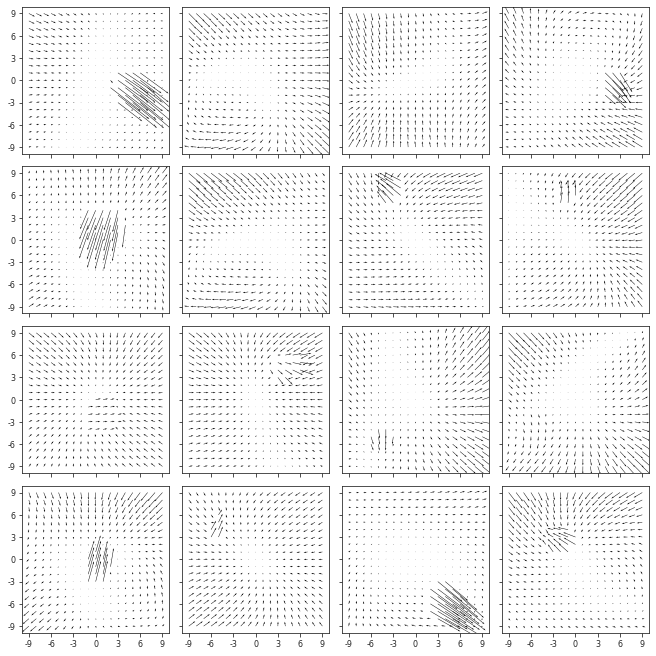

----------------------------------------------------------------------

fig/regression (VAE)

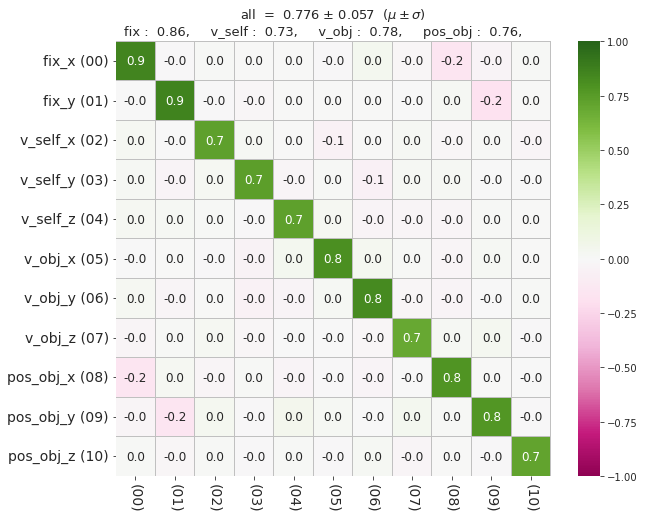

fig/regression (EMA)

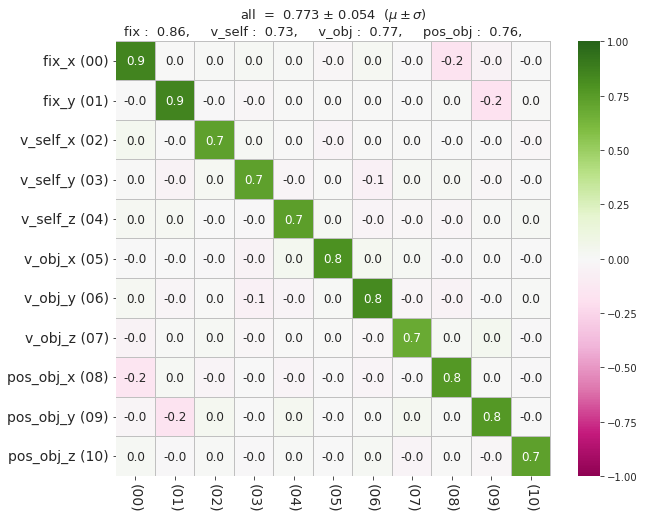

----------------------------------------------------------------------

fig/mutual_info (VAE)

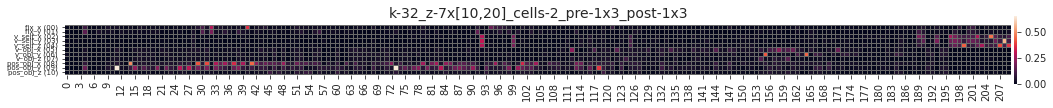

fig/mutual_info (EMA)

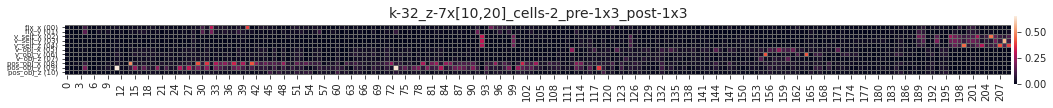

----------------------------------------------------------------------

In [6]:
for k, v in val.items():
    if 'fig' in k:
        print(f"{k} (VAE)")
        display(v)
        print(f"{k} (EMA)")
        display(val_ema[k])
        print('-' * 70)

In [8]:
mi = np.max(val['regr/mi'], axis=1).mean()
mi_ema = np.max(val_ema['regr/mi'], axis=1).mean()
mi, mi_ema

(0.3756599381333692, 0.3791011933177657)

In [10]:
tr.model.stem.log_weight_norm.exp()

tensor([1.0199, 1.0658, 1.0958, 1.0570, 1.0660, 1.0768, 1.0041, 1.1065, 1.0927,
        0.8894, 1.1248, 1.2083, 1.0933, 1.0982, 1.2267, 1.0946, 1.0049, 1.2088,
        1.3661, 1.1751, 1.0902, 1.0547, 1.1669, 1.0835, 1.0756, 0.9893, 0.9851,
        1.0716, 1.1086, 1.1291, 1.1967, 0.9556], device='cuda:2',
       grad_fn=<ExpBackward0>)

In [11]:
tr.model_ema.stem.log_weight_norm.exp()

tensor([1.0199, 1.0658, 1.0958, 1.0570, 1.0660, 1.0769, 1.0042, 1.1065, 1.0927,
        0.8894, 1.1248, 1.2083, 1.0933, 1.0983, 1.2268, 1.0947, 1.0049, 1.2088,
        1.3661, 1.1752, 1.0903, 1.0547, 1.1669, 1.0835, 1.0756, 0.9893, 0.9851,
        1.0716, 1.1086, 1.1291, 1.1968, 0.9556], device='cuda:2',
       grad_fn=<ExpBackward0>)

In [12]:
w = to_np(tr.model.stem.weight)
w.shape

(32, 2, 4, 4)

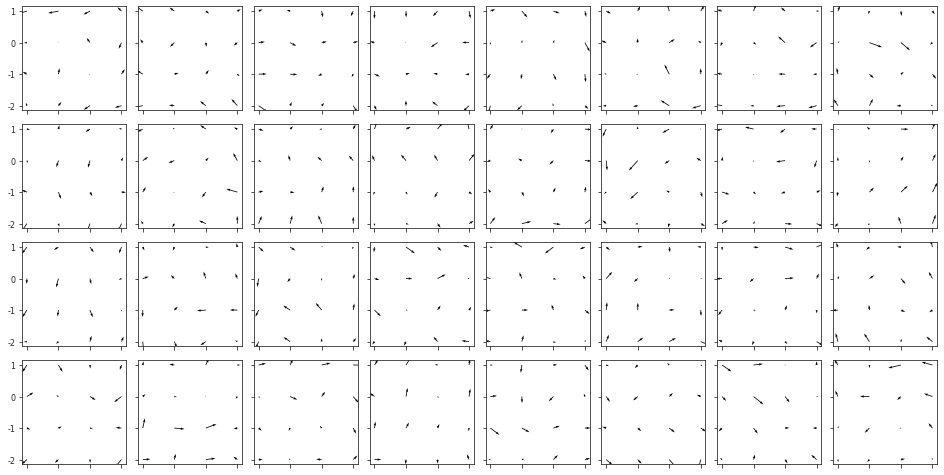

In [13]:
_ = show_opticflow(w, 8, figsize=(13,) * 2, tick_spacing=1)

In [17]:
scales, _ = tr.model.latent_scales()

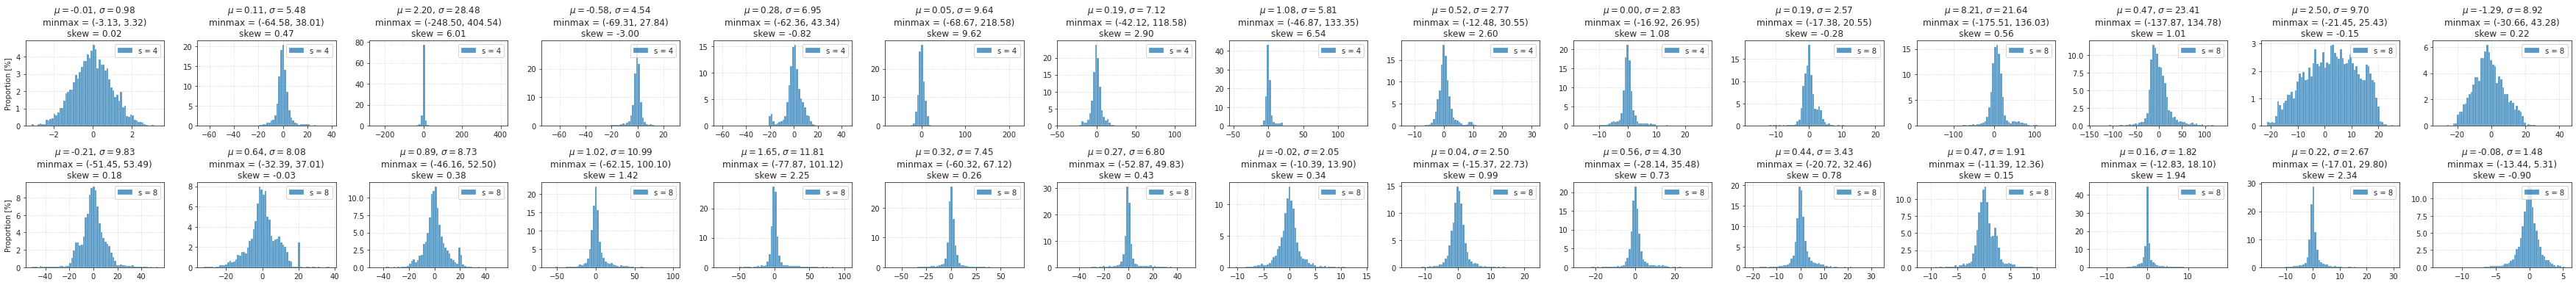

In [18]:
plot_latents_hist(val['z_sample'], scales);

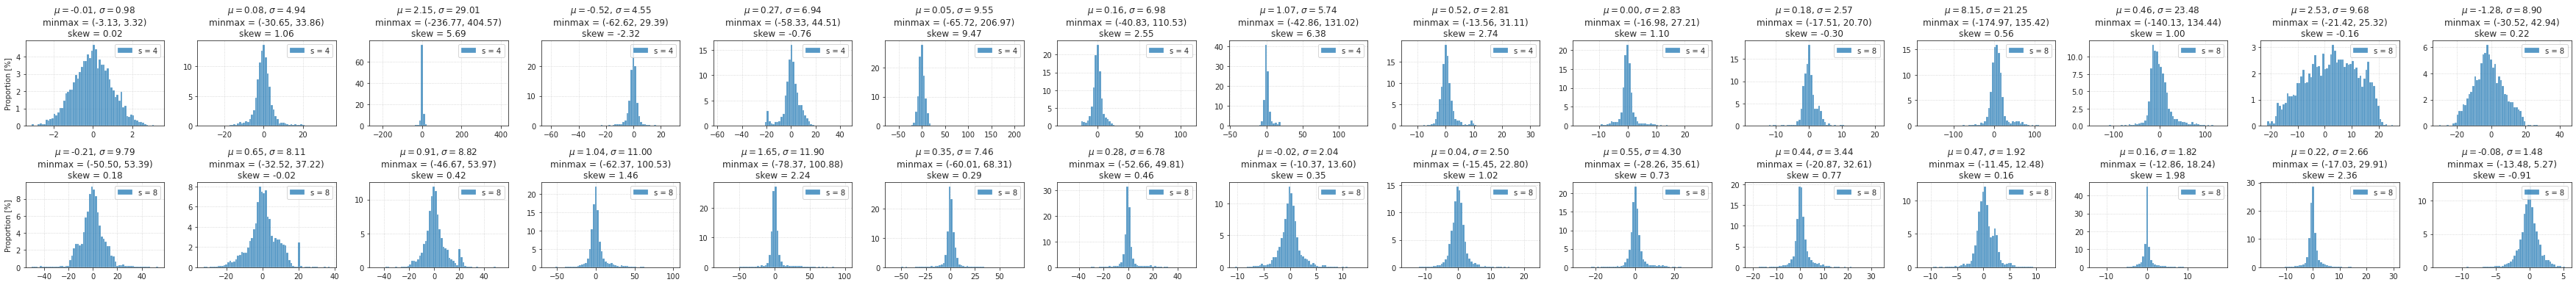

In [19]:
plot_latents_hist(val_ema['z_sample'], scales);

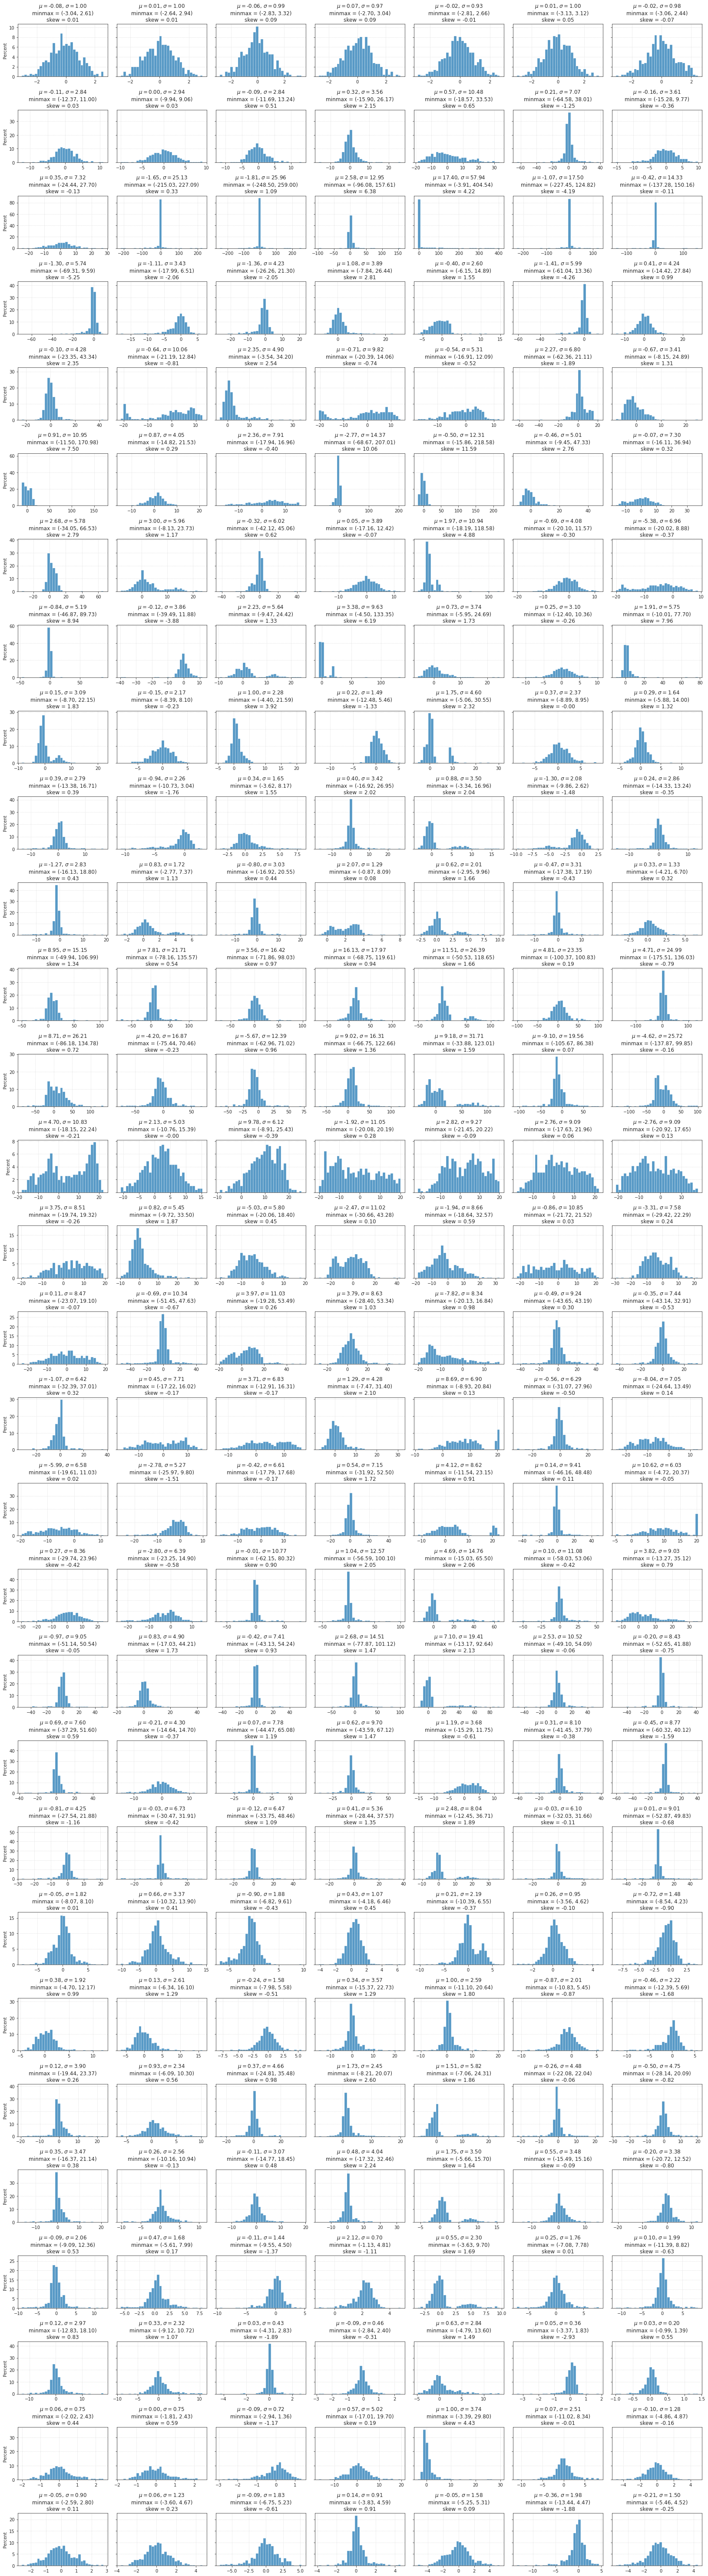

In [20]:
plot_latents_hist_full(val['z_sample'], scales);

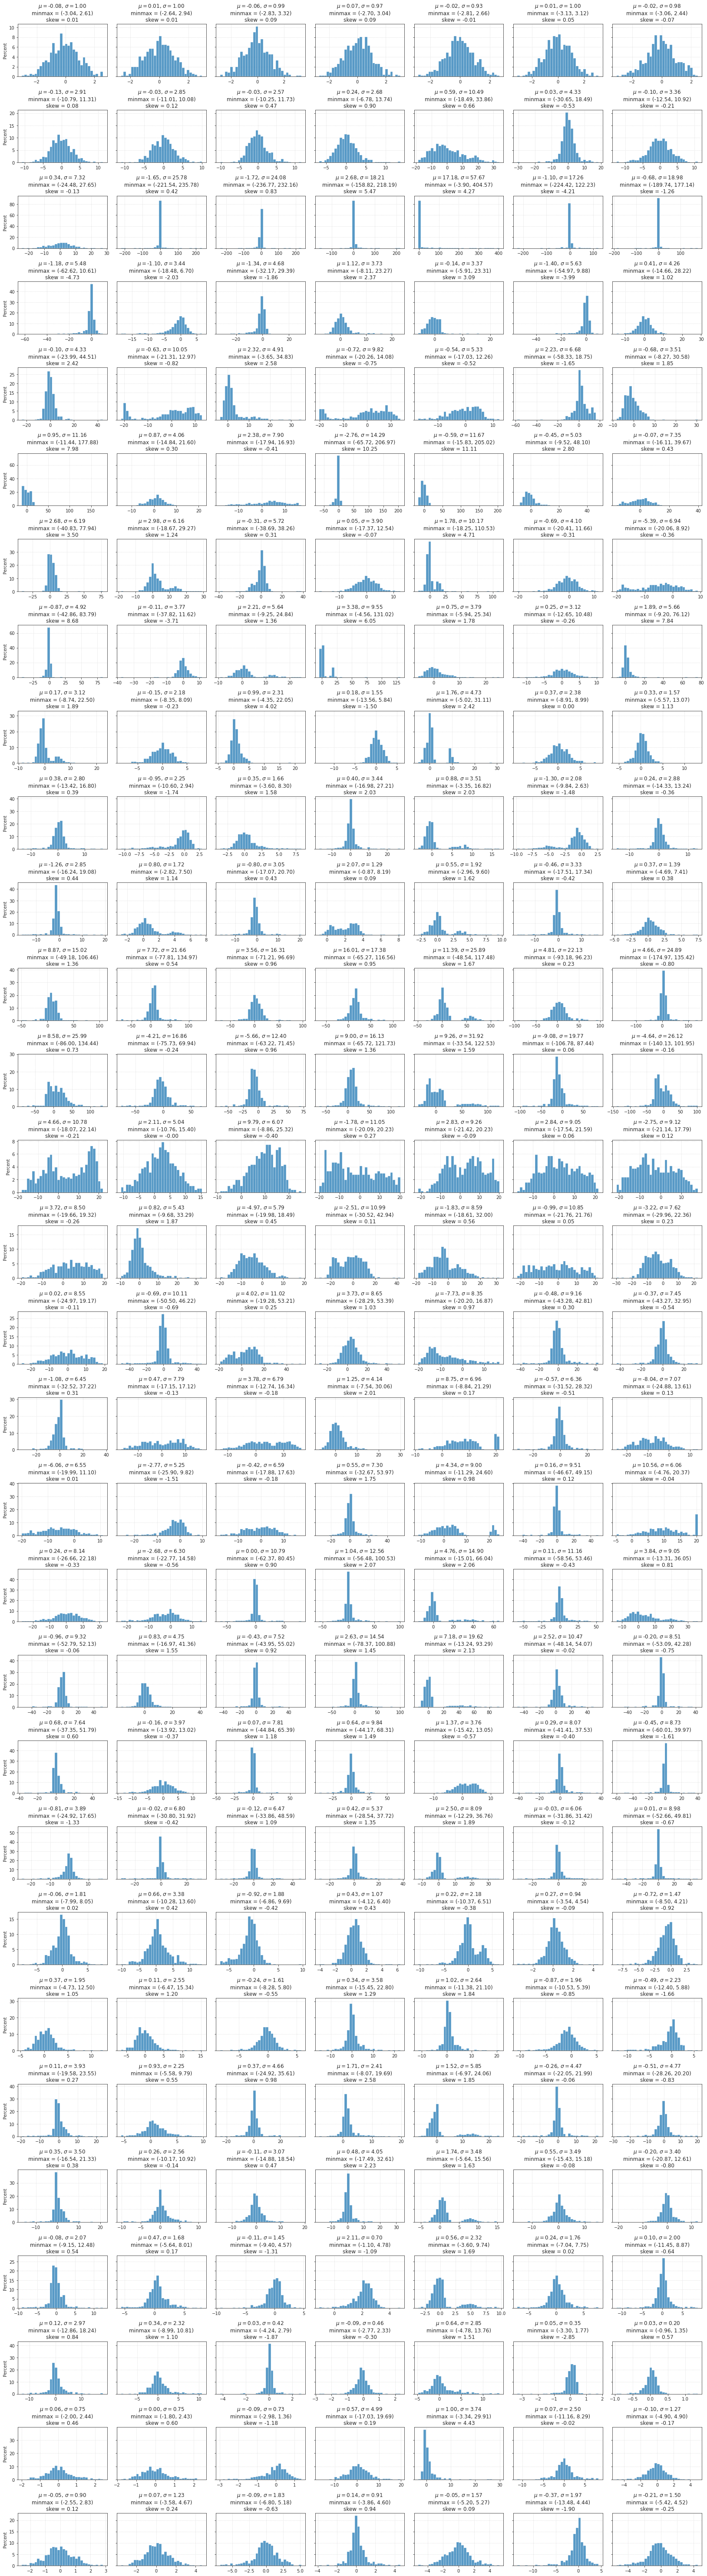

In [21]:
plot_latents_hist_full(val_ema['z_sample'], scales);

In [22]:
i, zz = np.unravel_index(np.argmin(val['z_sample']), val['z_sample'].shape)
i, zz

(232, 16)

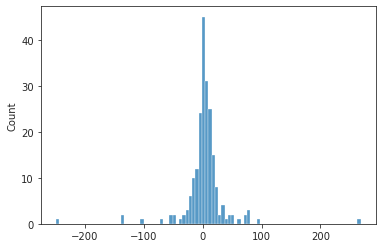

In [23]:
sns.histplot(val['z_sample'][i]);

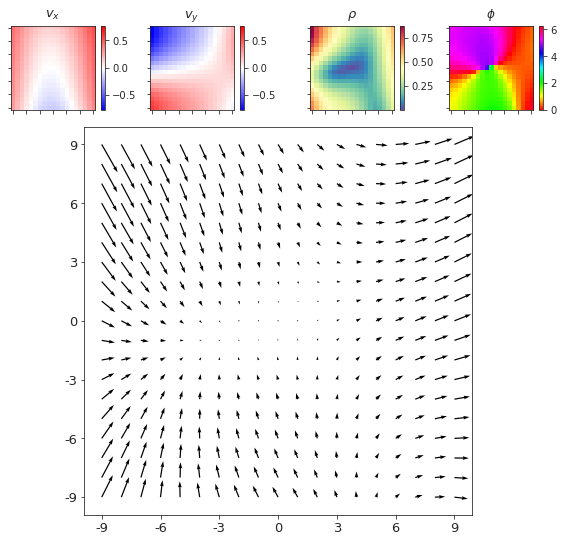

In [24]:
show_opticflow_full(val['x_sample'][i]);

In [25]:
i, zz = np.unravel_index(np.argmax(val['z_sample']), val['z_sample'].shape)
i, zz

(75, 18)

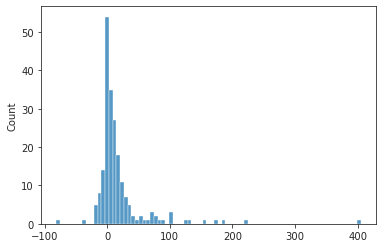

In [26]:
sns.histplot(val['z_sample'][i]);

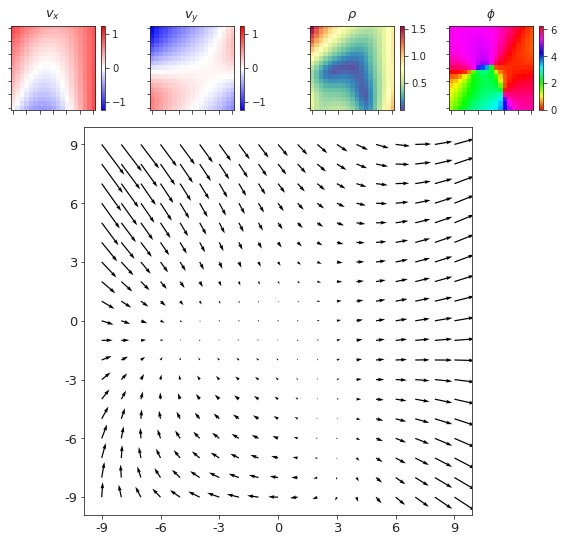

In [27]:
show_opticflow_full(val['x_sample'][i]);

In [31]:
i, zz = np.unravel_index(np.argmin(val_ema['z_sample']), val_ema['z_sample'].shape)
i, zz

(232, 16)

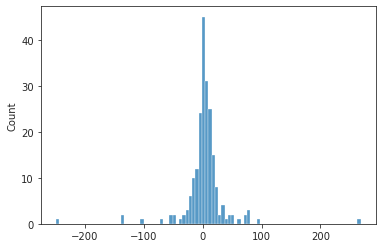

In [32]:
sns.histplot(val['z_sample'][i]);

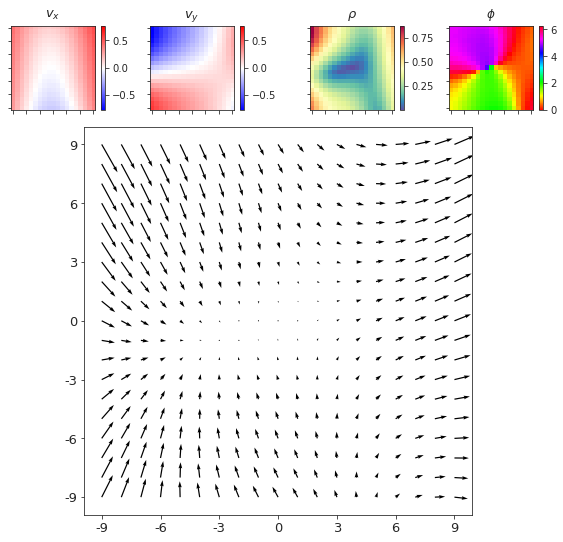

In [34]:
show_opticflow_full(val_ema['x_sample'][i]);

In [35]:
i, zz = np.unravel_index(np.argmax(val_ema['z_sample']), val_ema['z_sample'].shape)
i, zz

(75, 18)

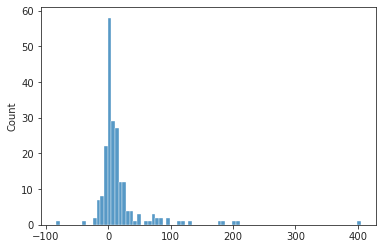

In [37]:
sns.histplot(val_ema['z_sample'][i]);

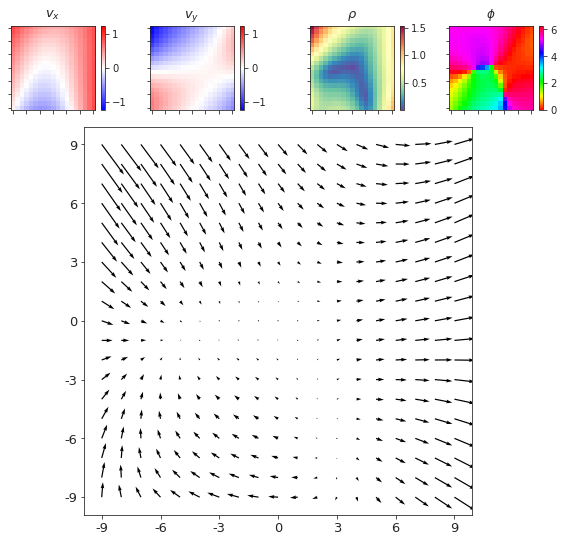

In [38]:
show_opticflow_full(val_ema['x_sample'][i]);

In [28]:
torch.abs(torch.cat(tr.model.all_log_norm)).sum()

tensor(592.0896, device='cuda:2', grad_fn=<SumBackward0>)

In [30]:
a = to_np(torch.abs(torch.cat(tr.model.all_log_norm)))

<AxesSubplot:ylabel='Count'>

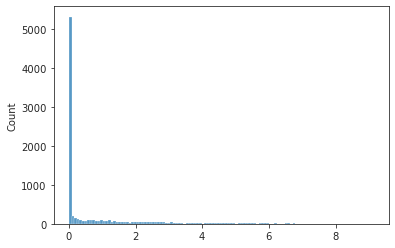

In [32]:
sns.histplot(a)

In [33]:
all_norms = to_np(torch.cat(tr.model.all_log_norm).exp())

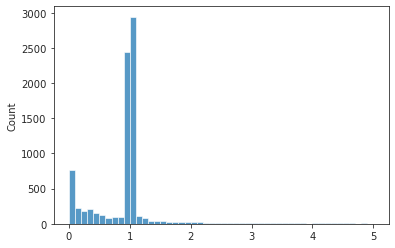

In [34]:
ax = sns.histplot(all_norms, bins=np.linspace(0, 5, 51));

In [35]:
np.max(all_norms)

365.48495

In [36]:
print(f"{np.round((all_norms > 5).sum() / len(all_norms) * 100, 1)} % of them are greated than 5")

4.9 % of them are greated than 5

In [42]:
w2p = {}
norms_expand = {}
for i, layer in enumerate(tr.model.expand):
    w2p[i] = to_np(layer.weight)
    _norm = to_np(torch.linalg.vector_norm(layer.weight, dim=[0, 2, 3]))
    norms_expand[i] = list(_norm)
print({i: np.round(v, 3) for i, v in norms_expand.items()})

{
    0: array([0.366, 0.405, 0.375, 0.365, 0.37 , 0.378, 0.364], dtype=float32),
    1: array([0.408, 0.406, 0.396, 0.407, 0.379, 0.378, 0.392], dtype=float32),
    2: array([0.65 , 0.317, 0.479, 0.372, 0.299, 0.422, 0.362], dtype=float32),
    3: array([0.459, 0.599, 0.593, 0.548, 0.55 , 0.676, 0.562], dtype=float32),
    4: array([0.901, 0.866, 0.791, 0.813, 0.898, 0.821, 0.796], dtype=float32),
    5: array([0.749, 0.745, 0.855, 0.66 , 0.771, 0.769, 0.708], dtype=float32),
    6: array([0.792, 0.739, 0.765, 0.73 , 0.713, 0.894, 0.811], dtype=float32),
    7: array([0.829, 0.769, 0.737, 0.828, 0.938, 0.704, 0.716], dtype=float32),
    8: array([0.777, 0.803, 0.754, 0.925, 0.868, 0.785, 0.711], dtype=float32),
    9: array([0.713, 0.802, 0.776, 0.865, 0.98 , 0.871, 0.758], dtype=float32),
    10: array([1.154, 1.155, 1.154, 1.155, 1.088, 1.14 , 1.27 ], dtype=float32),
    11: array([0.538, 0.589, 0.555, 0.622, 0.585, 0.591, 0.741], dtype=float32),
    12: array([0.648, 0.562, 0.612, 0.654, 0.544, 0.711, 0.613], dtype=float32),
    13: array([0.962, 1.027, 0.948, 0.931, 1.222, 0.947, 1.095], dtype=float32),
    14: array([0.884, 0.958, 0.938, 0.718, 1.215, 0.817, 0.775], dtype=float32),
    15: array([0.706, 0.715, 0.705, 0.722, 0.705, 0.673, 0.813], dtype=float32),
    16: array([0.958, 1.165, 1.314, 1.17 , 1.208, 0.983, 1.105], dtype=float32),
    17: array([1.077, 1.119, 1.002, 1.137, 1.114, 1.102, 1.07 ], dtype=float32),
    18: array([0.82 , 0.821, 0.993, 0.983, 0.971, 0.669, 0.911], dtype=float32),
    19: array([1.094, 0.82 , 1.08 , 0.946, 0.747, 0.809, 1.056], dtype=float32),
    20: array([0.87 , 1.153, 1.008, 0.942, 1.018, 0.956, 0.842], dtype=float32),
    21: array([0.976, 0.99 , 1.155, 0.984, 0.619, 1.179, 1.039], dtype=float32),
    22: array([1.342, 1.366, 1.269, 1.114, 1.137, 1.286, 1.143], dtype=float32),
    23: array([1.113, 1.027, 0.99 , 0.929, 0.935, 1.164, 0.994], dtype=float32),
    24: array([1.084, 0.932, 1.027, 0.828, 0.903, 0.904, 0.897], dtype=float32),
    25: array([0.964, 0.772, 1.011, 1.041, 0.909, 1.077, 0.769], dtype=float32),
    26: array([0.832, 0.546, 0.648, 1.248, 0.554, 0.814, 0.817], dtype=float32),
    27: array([1.283, 1.304, 1.426, 1.379, 1.23 , 1.358, 1.381], dtype=float32),
    28: array([1.429, 1.244, 1.853, 1.684, 1.445, 1.331, 1.252], dtype=float32),
    29: array([1.022, 1.081, 1.14 , 0.953, 0.966, 1.115, 1.038], dtype=float32)
}

In [43]:
print({i: np.round(np.mean(v), 3) for i, v in norms_expand.items()})

{
    0: 0.375,
    1: 0.395,
    2: 0.415,
    3: 0.569,
    4: 0.841,
    5: 0.751,
    6: 0.778,
    7: 0.789,
    8: 0.803,
    9: 0.824,
    10: 1.16,
    11: 0.603,
    12: 0.621,
    13: 1.019,
    14: 0.901,
    15: 0.72,
    16: 1.129,
    17: 1.089,
    18: 0.881,
    19: 0.936,
    20: 0.97,
    21: 0.992,
    22: 1.237,
    23: 1.022,
    24: 0.939,
    25: 0.935,
    26: 0.78,
    27: 1.337,
    28: 1.463,
    29: 1.045
}

In [44]:
w2p = {}
norms_expand = {}
for i, layer in enumerate(tr.model_ema.expand):
    w2p[i] = to_np(layer.weight)
    _norm = to_np(torch.linalg.vector_norm(layer.weight, dim=[0, 2, 3]))
    norms_expand[i] = list(_norm)
print({i: np.round(v, 3) for i, v in norms_expand.items()})

{
    0: array([0.366, 0.405, 0.375, 0.365, 0.37 , 0.378, 0.364], dtype=float32),
    1: array([0.408, 0.406, 0.396, 0.407, 0.379, 0.378, 0.392], dtype=float32),
    2: array([0.65 , 0.317, 0.479, 0.372, 0.299, 0.422, 0.362], dtype=float32),
    3: array([0.459, 0.599, 0.593, 0.547, 0.55 , 0.675, 0.562], dtype=float32),
    4: array([0.901, 0.866, 0.791, 0.813, 0.898, 0.821, 0.796], dtype=float32),
    5: array([0.749, 0.745, 0.855, 0.66 , 0.771, 0.769, 0.708], dtype=float32),
    6: array([0.792, 0.739, 0.765, 0.73 , 0.713, 0.894, 0.811], dtype=float32),
    7: array([0.829, 0.77 , 0.738, 0.828, 0.938, 0.704, 0.716], dtype=float32),
    8: array([0.777, 0.803, 0.754, 0.925, 0.868, 0.785, 0.711], dtype=float32),
    9: array([0.713, 0.802, 0.776, 0.865, 0.98 , 0.871, 0.758], dtype=float32),
    10: array([1.155, 1.156, 1.154, 1.155, 1.088, 1.14 , 1.27 ], dtype=float32),
    11: array([0.538, 0.589, 0.555, 0.623, 0.585, 0.591, 0.741], dtype=float32),
    12: array([0.649, 0.562, 0.613, 0.655, 0.544, 0.712, 0.614], dtype=float32),
    13: array([0.962, 1.027, 0.947, 0.931, 1.222, 0.947, 1.095], dtype=float32),
    14: array([0.884, 0.958, 0.938, 0.718, 1.215, 0.817, 0.775], dtype=float32),
    15: array([0.706, 0.715, 0.705, 0.722, 0.705, 0.673, 0.813], dtype=float32),
    16: array([0.958, 1.165, 1.313, 1.17 , 1.207, 0.982, 1.105], dtype=float32),
    17: array([1.077, 1.119, 1.002, 1.137, 1.114, 1.102, 1.07 ], dtype=float32),
    18: array([0.82 , 0.821, 0.993, 0.983, 0.971, 0.669, 0.911], dtype=float32),
    19: array([1.094, 0.82 , 1.08 , 0.945, 0.747, 0.809, 1.056], dtype=float32),
    20: array([0.87 , 1.153, 1.009, 0.943, 1.018, 0.957, 0.842], dtype=float32),
    21: array([0.977, 0.991, 1.155, 0.985, 0.619, 1.179, 1.039], dtype=float32),
    22: array([1.342, 1.366, 1.269, 1.114, 1.137, 1.286, 1.143], dtype=float32),
    23: array([1.113, 1.027, 0.99 , 0.929, 0.935, 1.164, 0.993], dtype=float32),
    24: array([1.085, 0.932, 1.027, 0.828, 0.903, 0.904, 0.897], dtype=float32),
    25: array([0.965, 0.772, 1.011, 1.042, 0.909, 1.077, 0.77 ], dtype=float32),
    26: array([0.833, 0.547, 0.649, 1.249, 0.554, 0.814, 0.818], dtype=float32),
    27: array([1.283, 1.304, 1.426, 1.379, 1.23 , 1.358, 1.38 ], dtype=float32),
    28: array([1.429, 1.244, 1.853, 1.684, 1.445, 1.33 , 1.252], dtype=float32),
    29: array([1.022, 1.081, 1.14 , 0.953, 0.966, 1.115, 1.038], dtype=float32)
}

In [45]:
tr.model.print()

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|     VAE     |  17.0 Mil  |
|     ---     |    ---     |
|     stem    |   1.1 K    |
|     pre     |   96.0 K   |
|  enc_tower  |  9.4 Mil   |
| enc_sampler |  1.4 Mil   |
| dec_sampler |  1.4 Mil   |
|    expand   |   70.8 K   |
|  dec_tower  |  4.5 Mil   |
|     post    |   40.0 K   |
|     out     |    578     |
|  cos_recon  |     0      |
|   l2_recon  |     0      |
|   l1_recon  |     0      |
|  l1_weight  |     0      |
+-------------+------------+

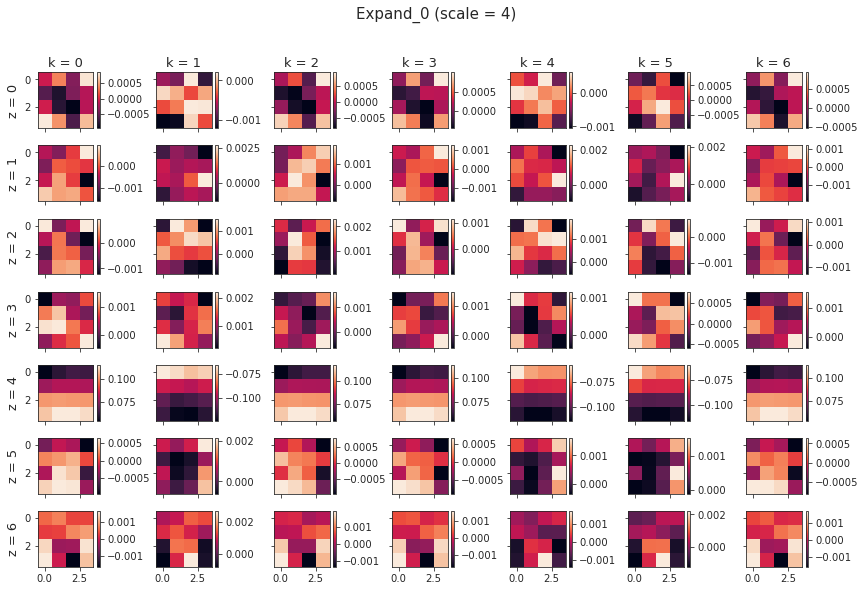

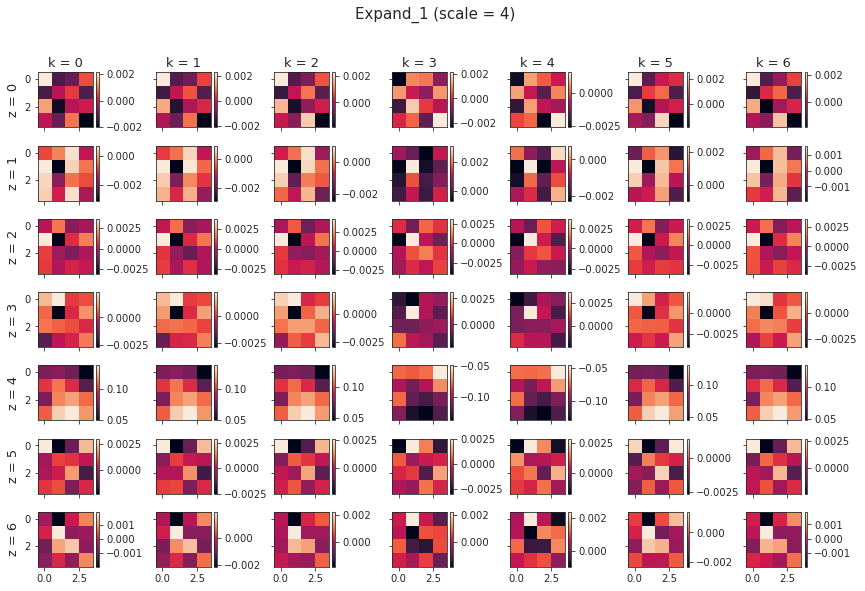

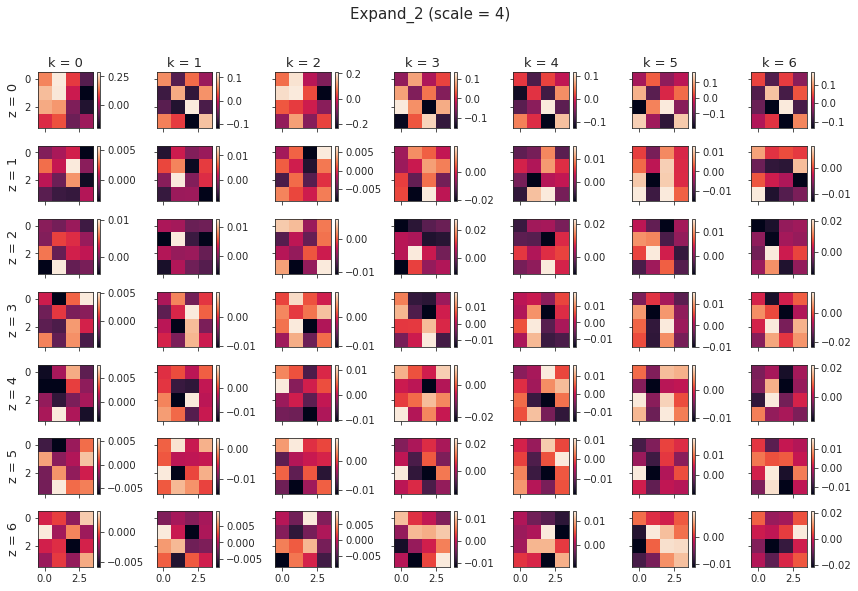

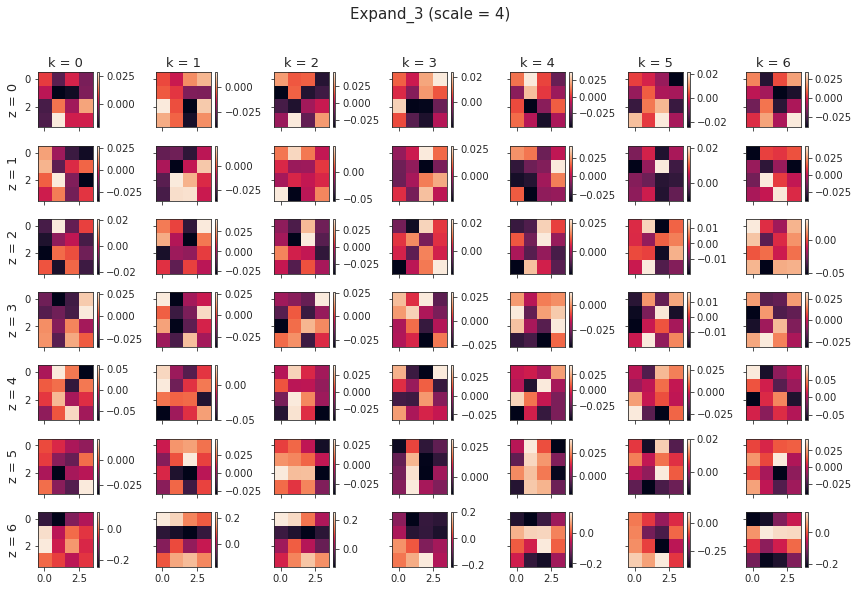

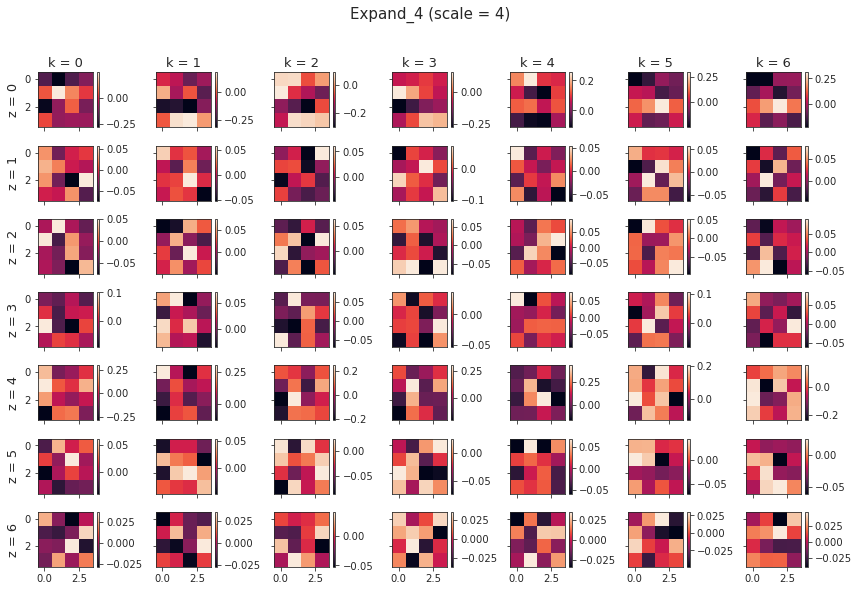

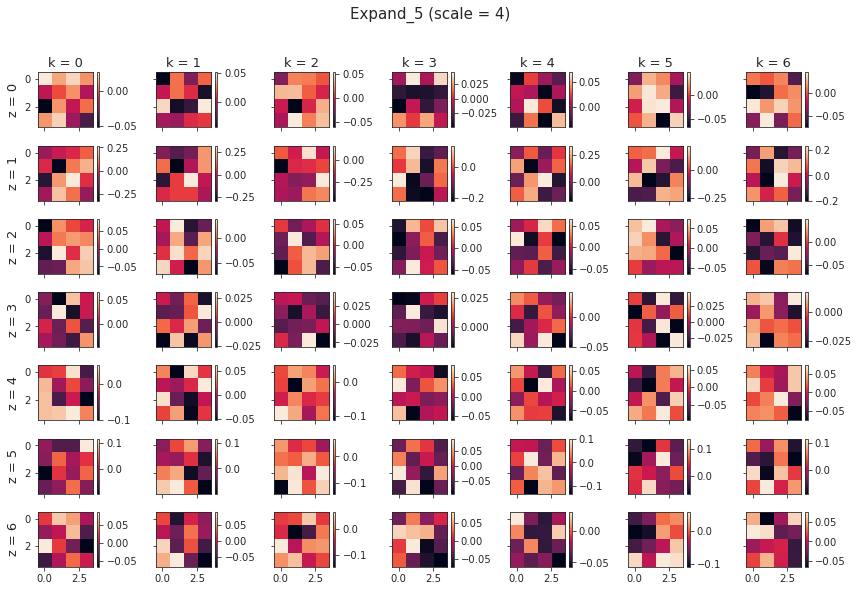

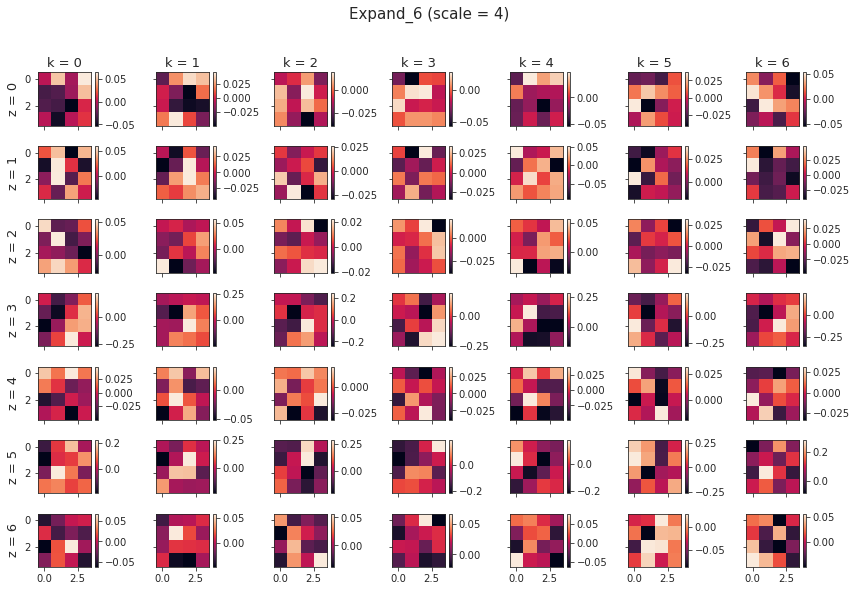

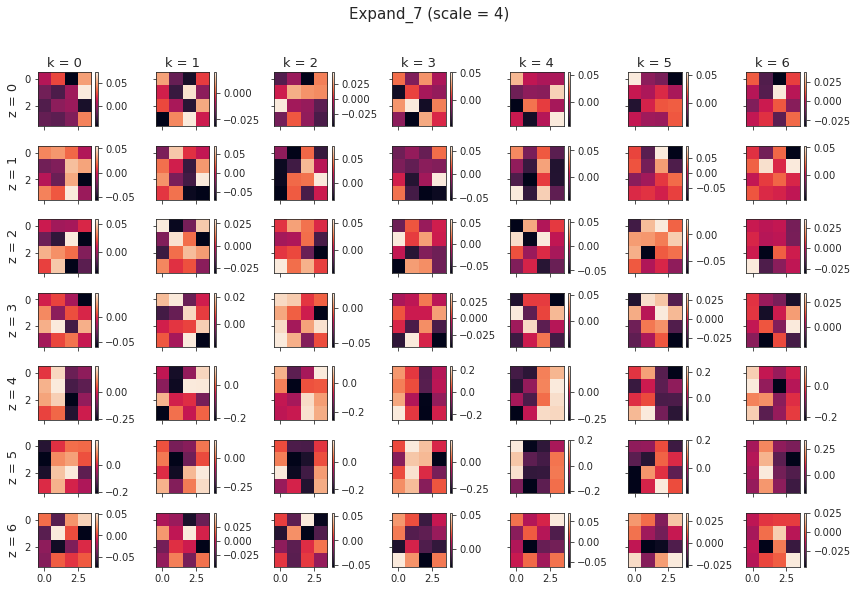

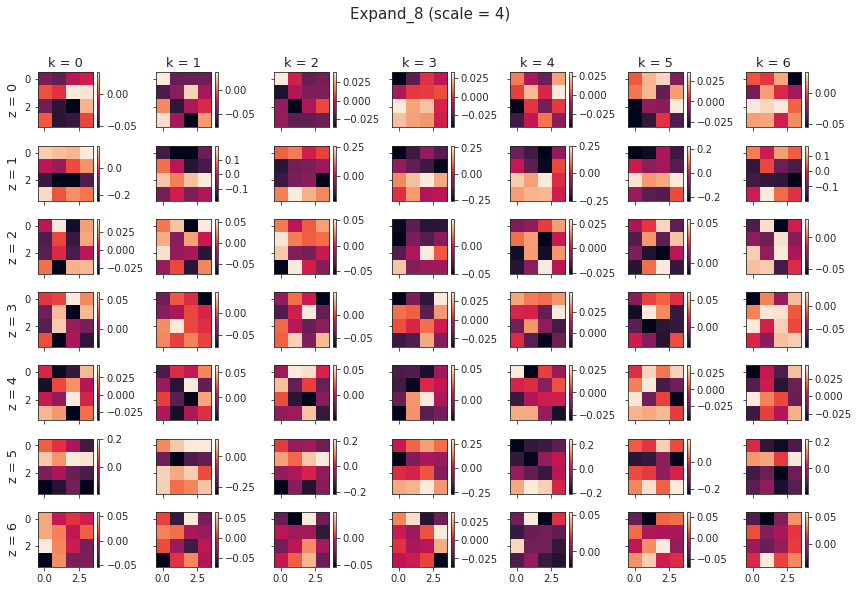

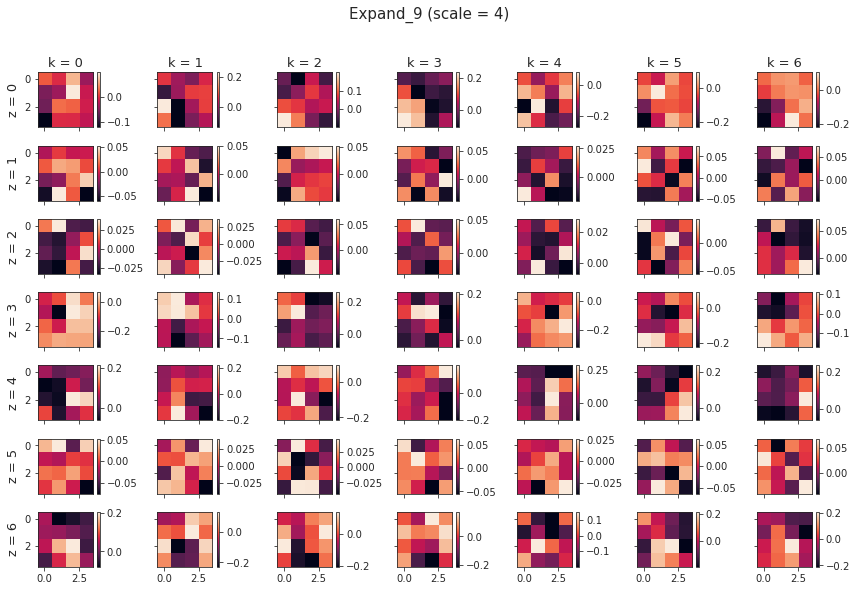

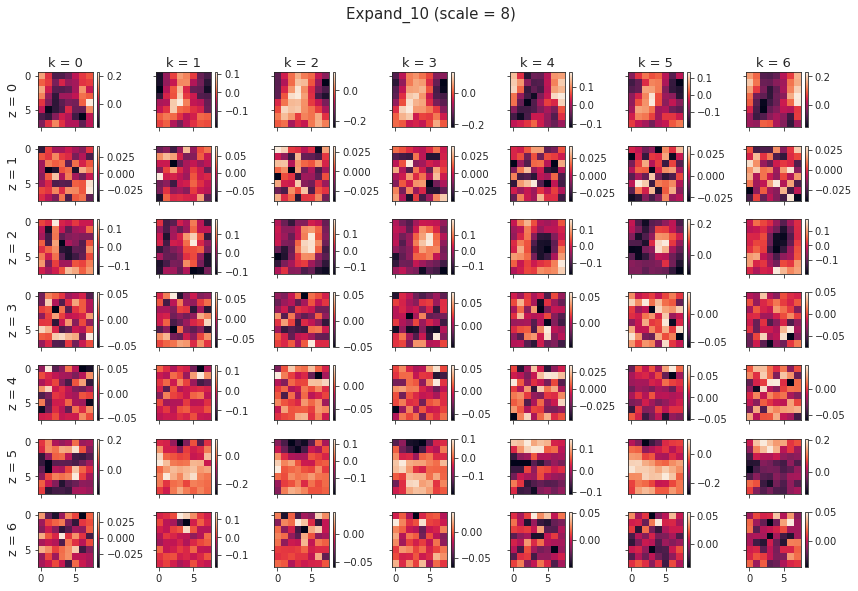

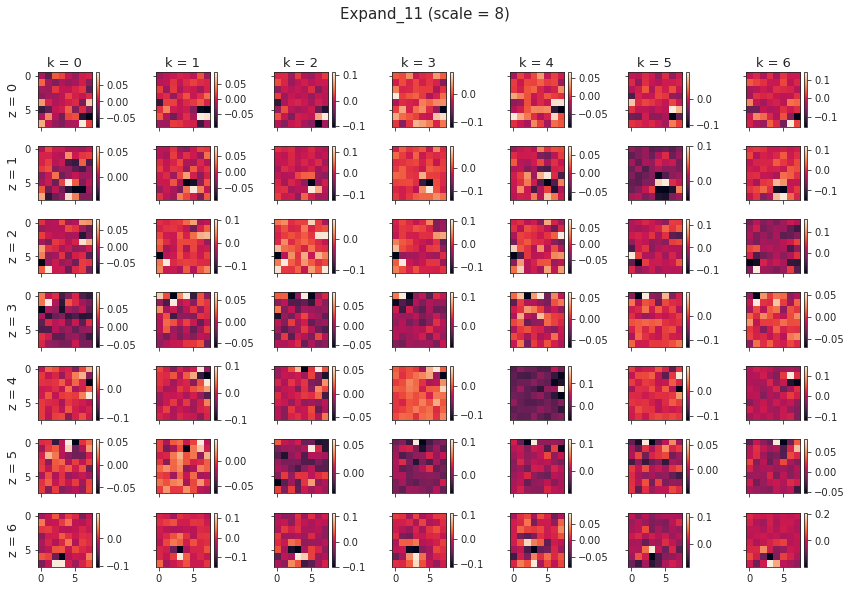

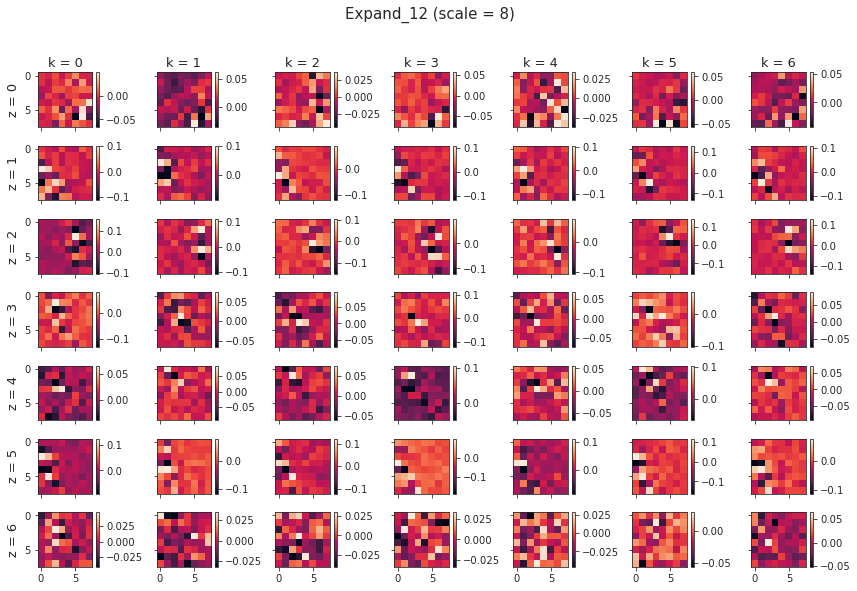

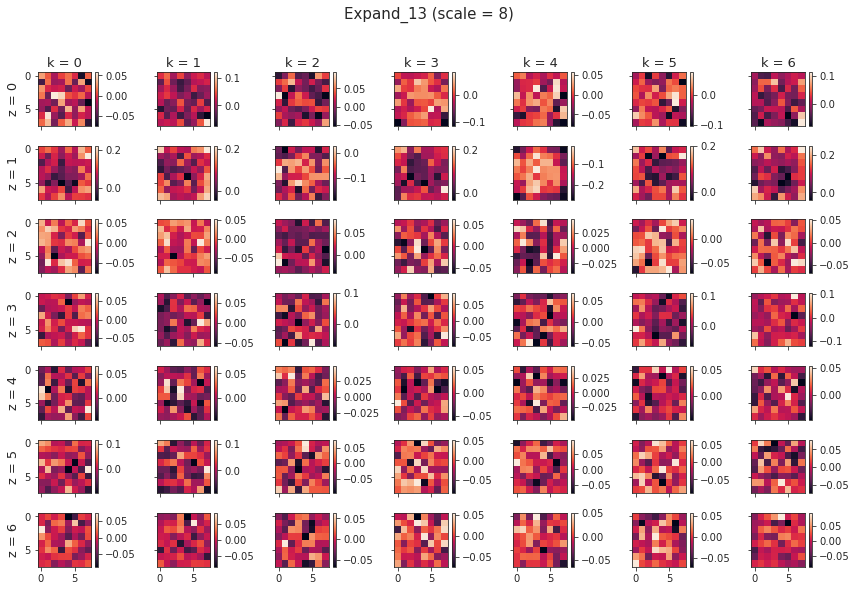

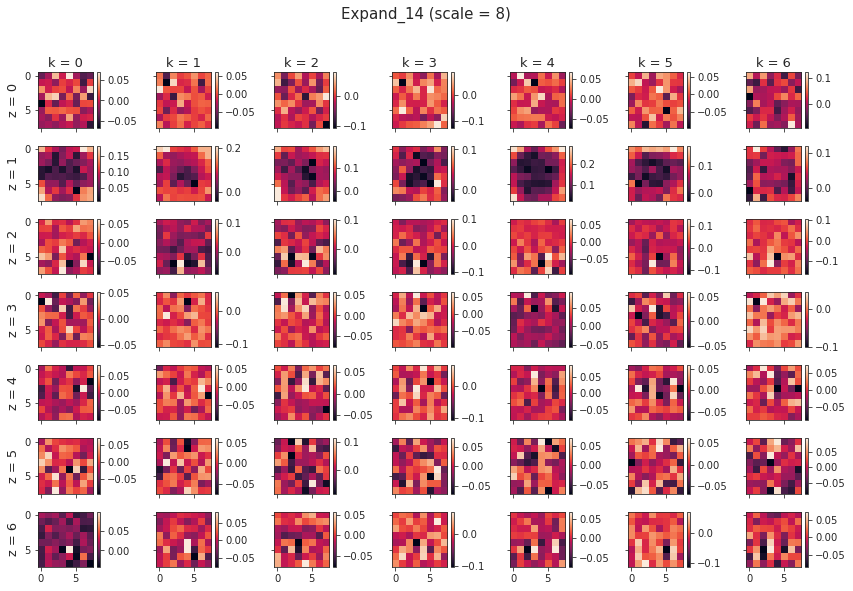

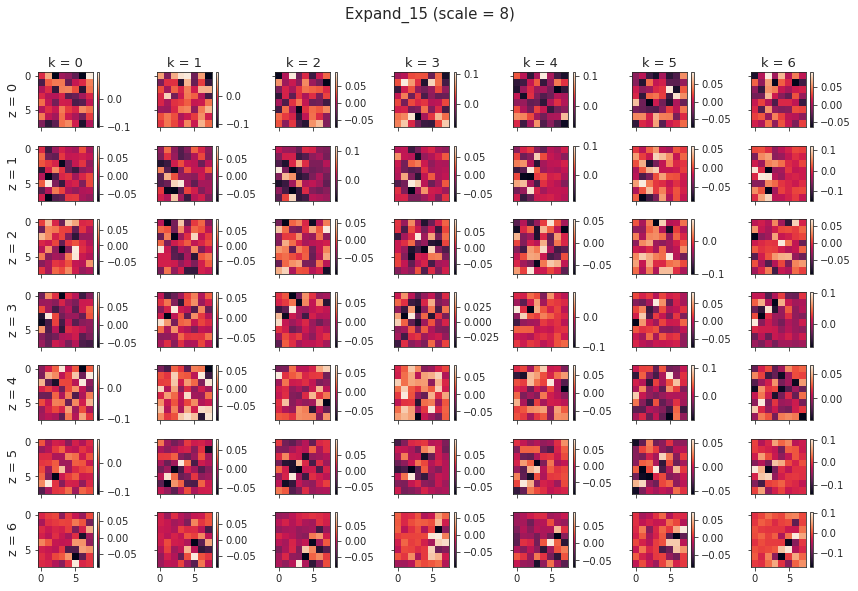

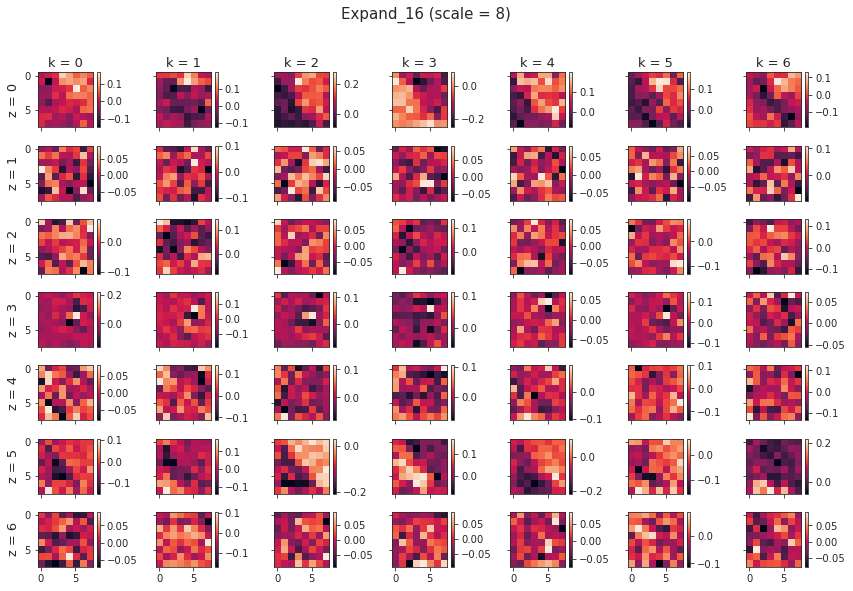

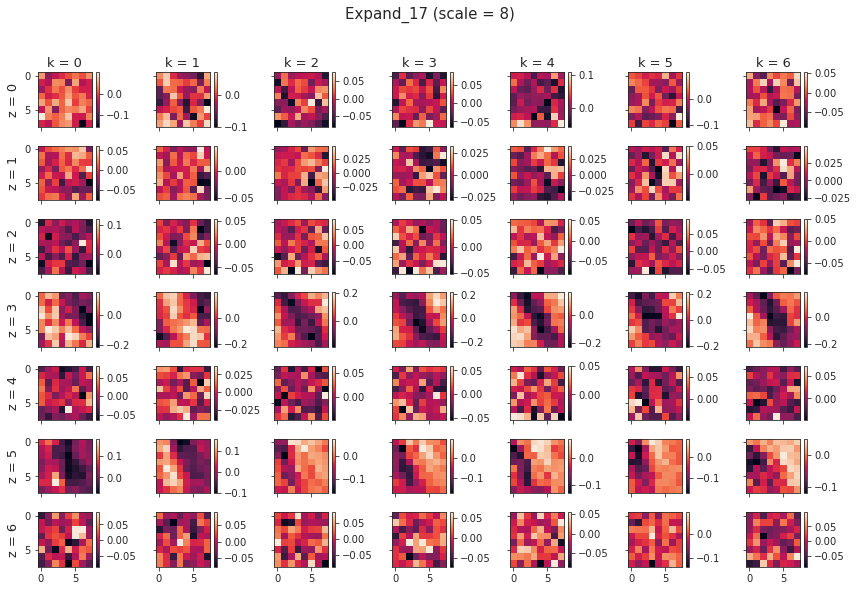

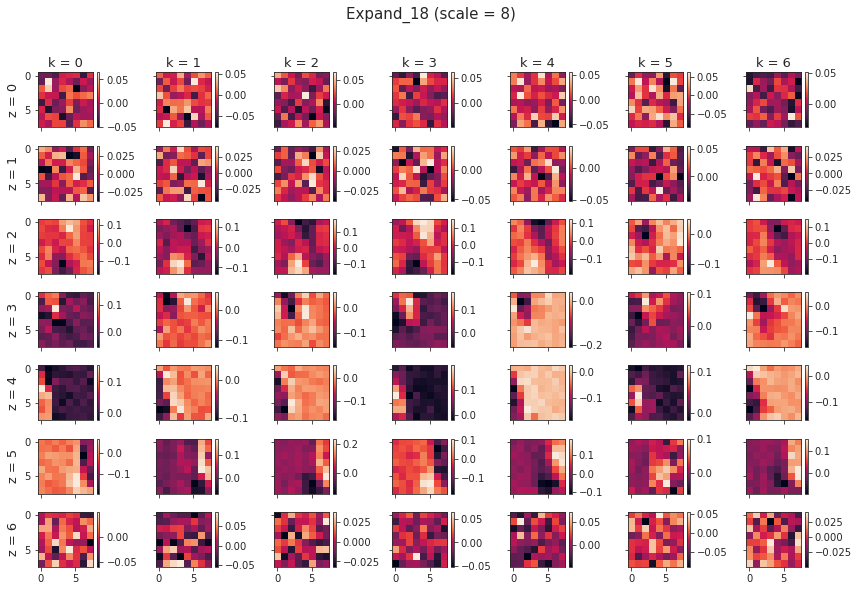

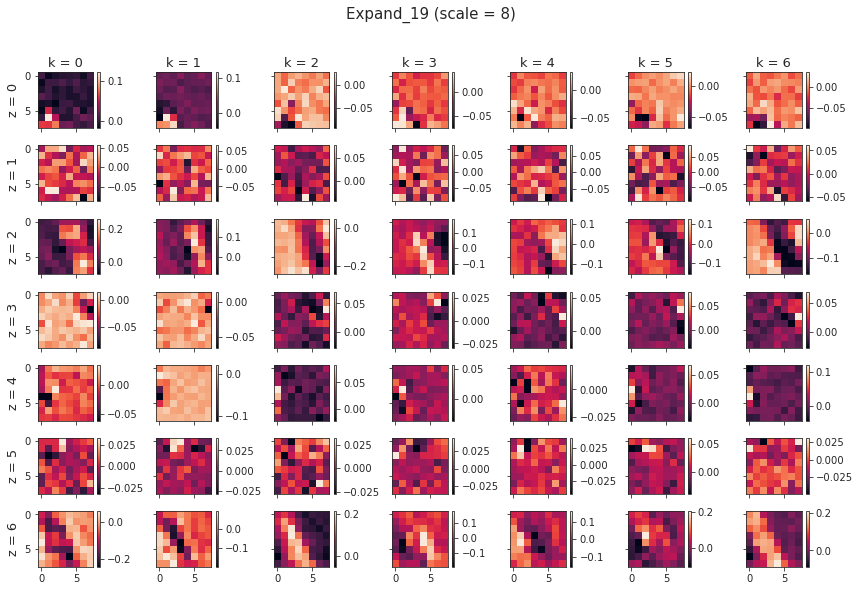

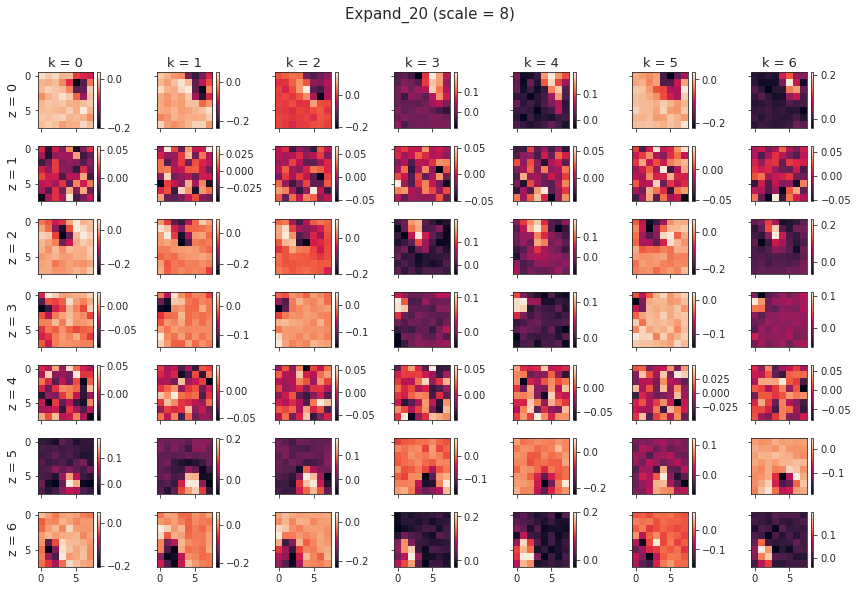

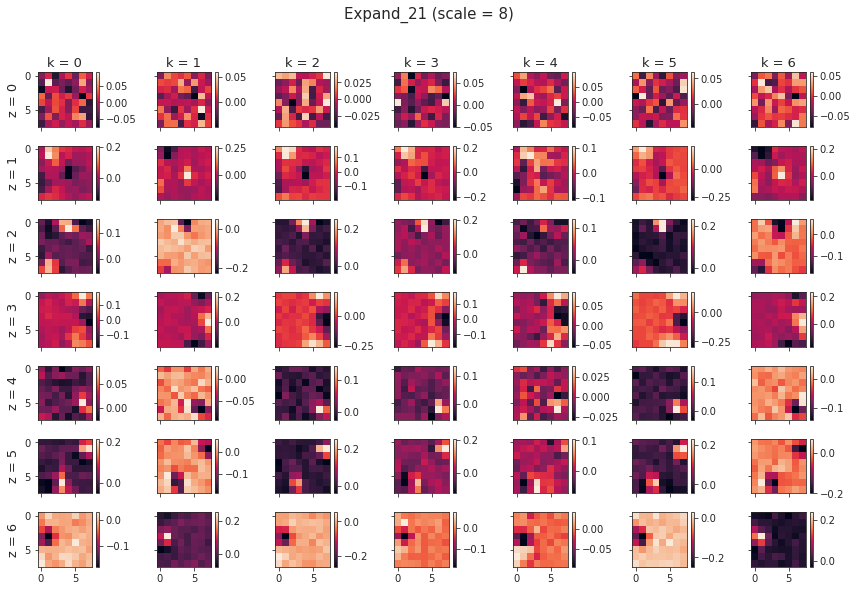

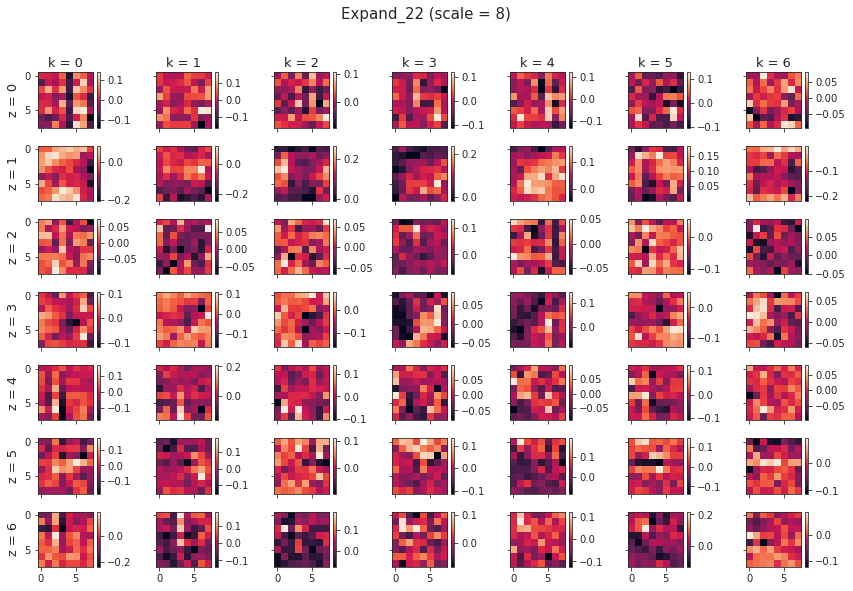

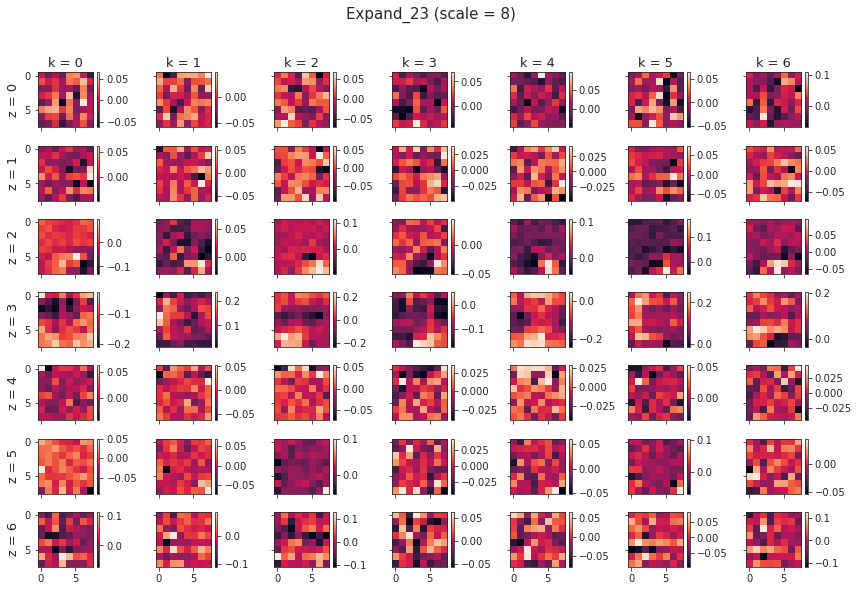

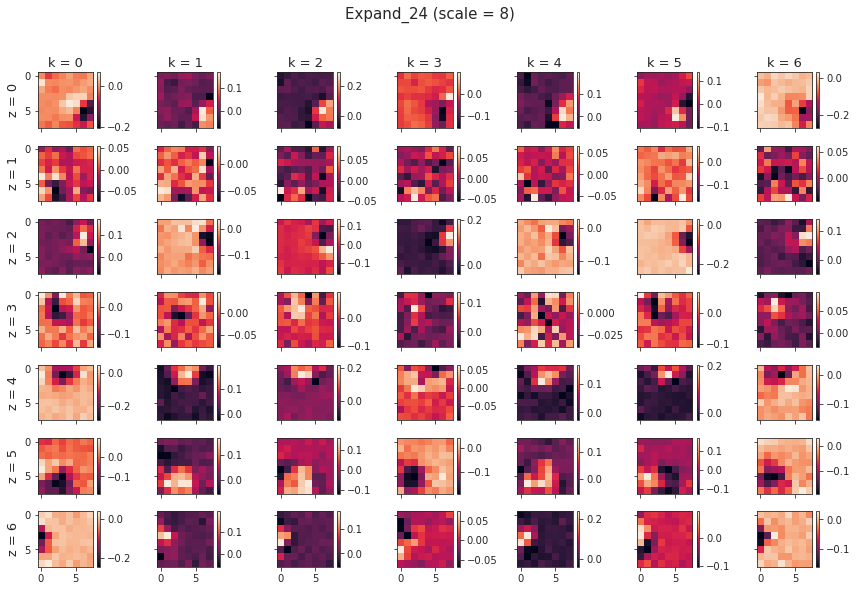

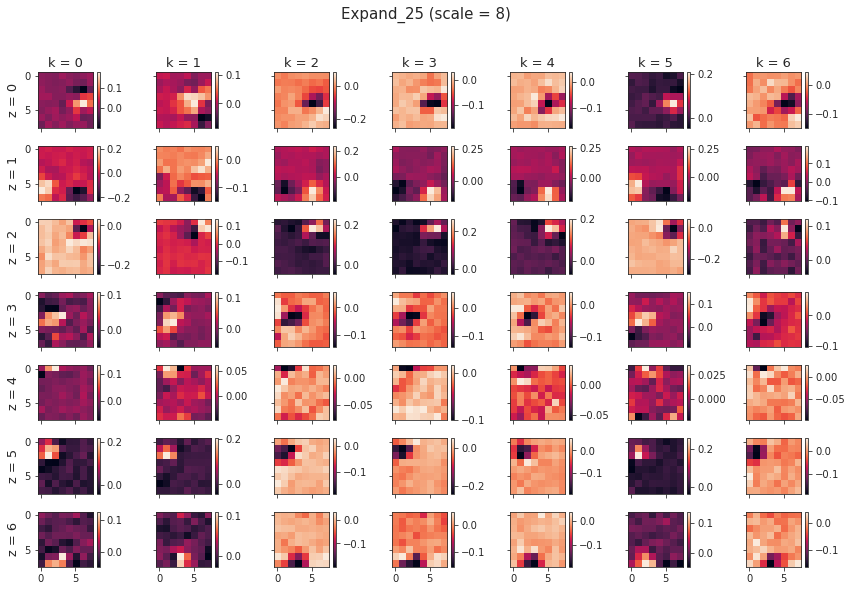

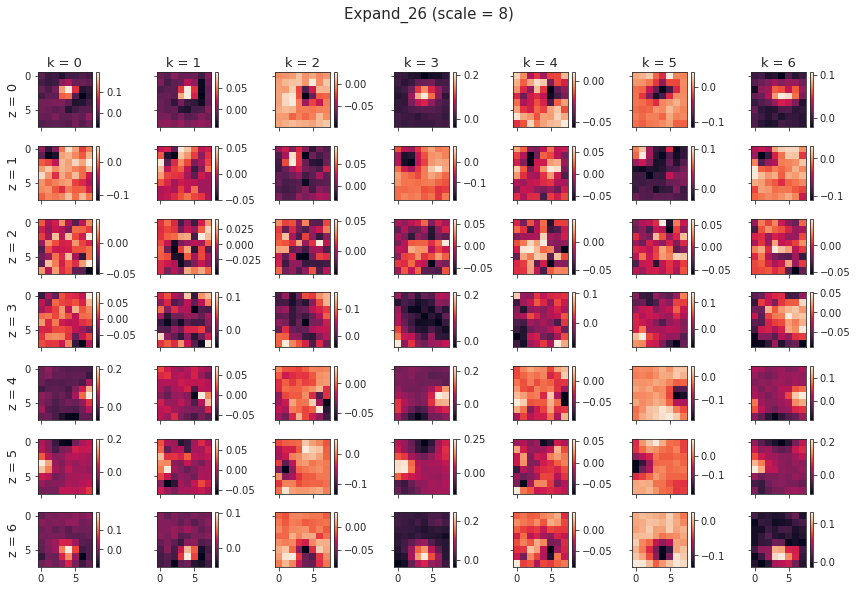

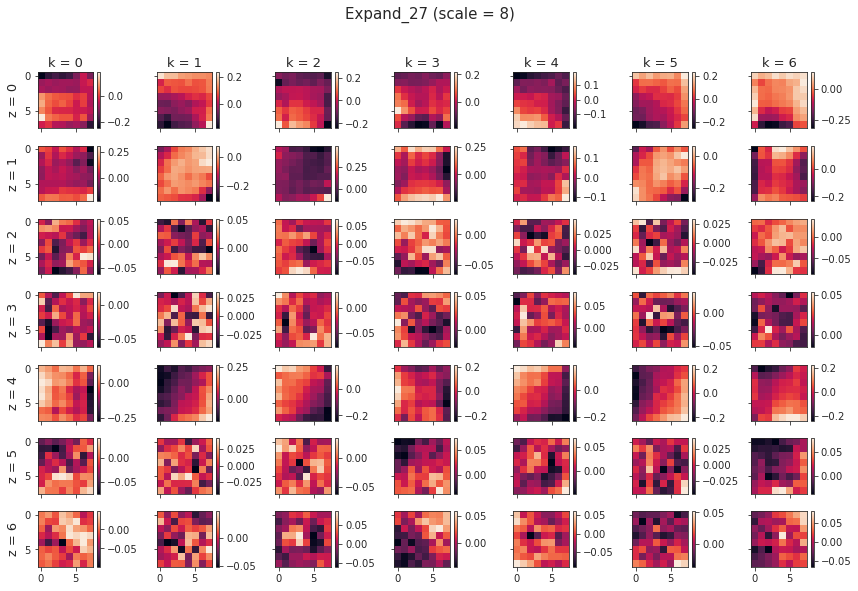

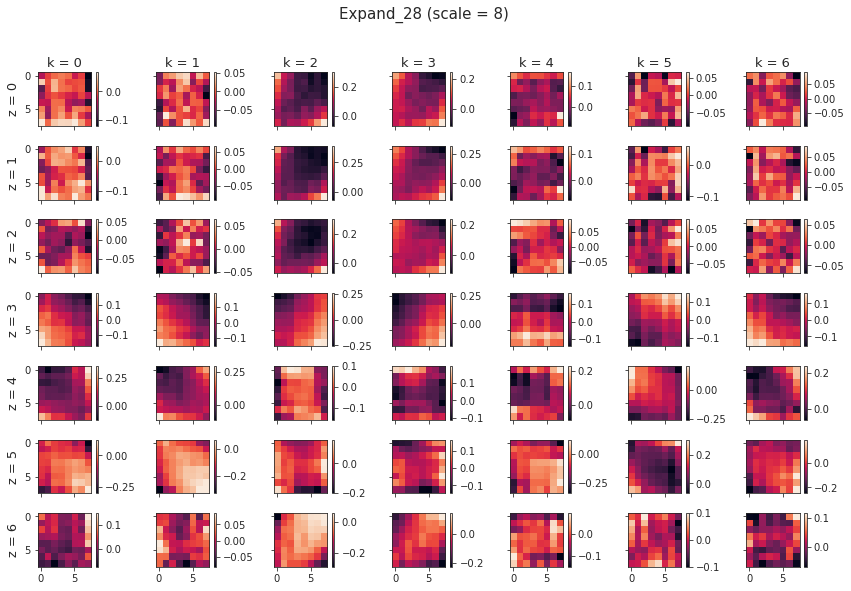

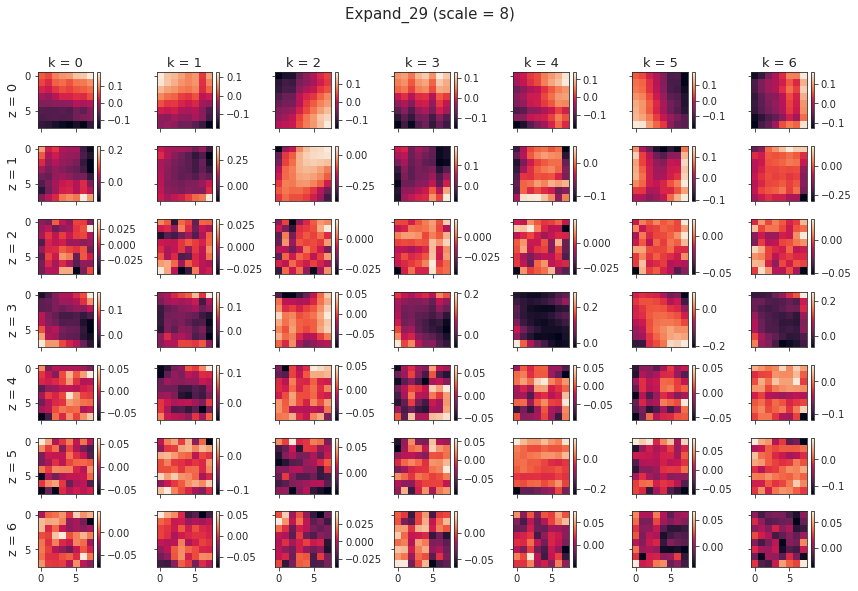

In [65]:
scales, _ = tr.model.latent_scales()
num = tr.model.cfg.n_latent_per_group

for i, _w in w2p.items():
    fig, axes = create_figure(num, num, (12, 8), 'all', 'all', tight_layout=True)
    for z, k in itertools.product(range(num), range(num)):
        ax = axes[z, k]
        im = ax.imshow(_w[z, k])
        plt.colorbar(im, ax=ax)
        if z == 0:
            ax.set_title(f"k = {k}", fontsize=13)
        if k == 0:
            ax.set_ylabel(f"z = {z}", fontsize=13)
    fig.suptitle(f'Expand_{i} (scale = {scales[i]})', fontsize=15, y=1.02)
    plt.show()

## Latent Traversal

In [437]:
self = tr.model_ema

In [438]:
n = 16
x_sample, z, _ = self.sample(n, device=tr.device)
# z = torch.cat(z, dim=1).squeeze()

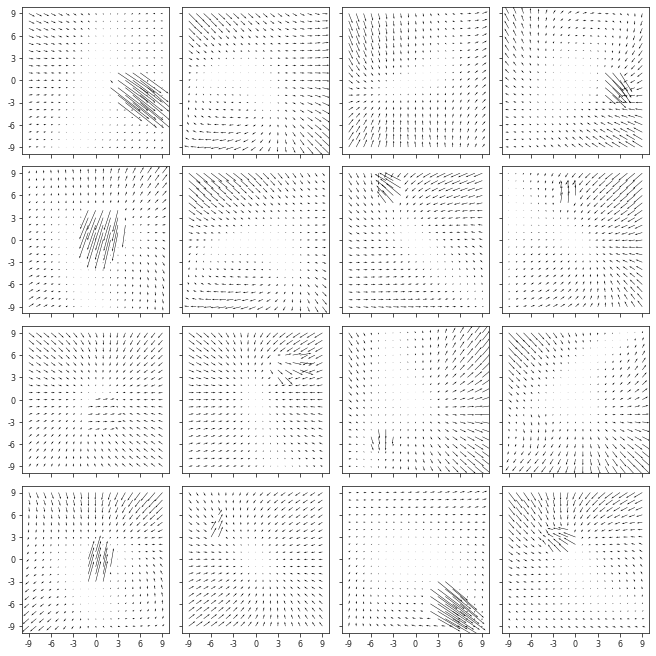

In [439]:
show_opticflow(x_sample);

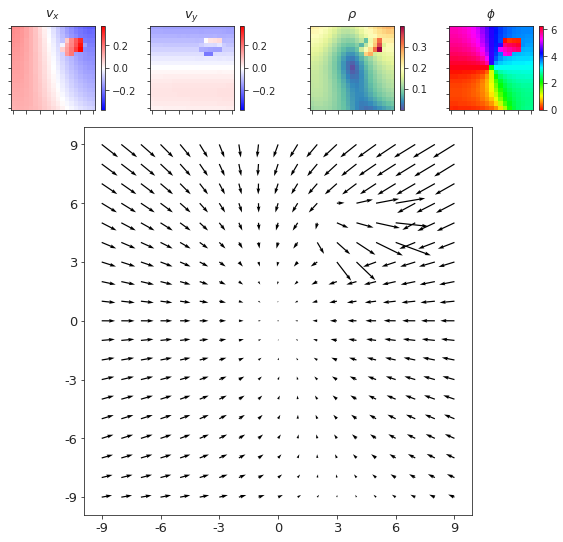

In [508]:
which_sample = 9
show_opticflow_full(x_sample[which_sample]);

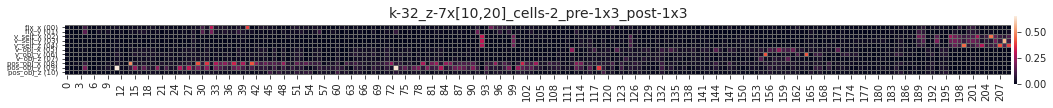

In [509]:
val_ema['fig/mutual_info']

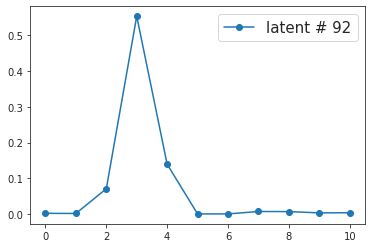

In [545]:
which_group = 29
which_latent = 5
i = which_group * self.cfg.n_latent_per_group + which_latent
plt.plot(val_ema['regr/mi'][:, i], marker='o', label=f'latent # {which_idx}')
plt.legend(fontsize=15);

<AxesSubplot:ylabel='Count'>

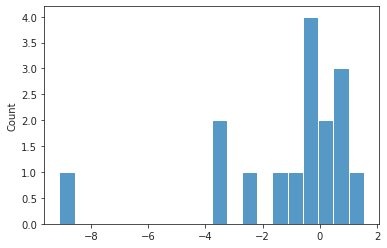

In [546]:
sns.histplot(to_np(z[which_group][:, which_latent]).ravel(), bins=20)

In [547]:
value = z[which_group][which_sample, which_latent].squeeze().item()
value

-0.3469189405441284

In [548]:
delta = 1
low = value - delta * (n // 2)
high = value + delta * (n // 2)
# low = value
# high = value + delta * n

z_traverse = torch.linspace(low, high, n).to(device)
z_traverse = z_traverse.unsqueeze(-1).unsqueeze(-1)

latents = [e[[which_sample]].repeat(n, 1, 1, 1) for e in z]
latents[which_group][:, which_latent] = z_traverse

In [549]:
idx = 0
s = self.prior_ftr0.unsqueeze(0)
s = s.expand(latents[idx].size(0), -1, -1, -1)
for cell in self.dec_tower:
    if isinstance(cell, CombinerDec):
        if idx > 0:
            _ = self.dec_sampler[idx - 1](s)
        s = cell(s, self.expand[idx](latents[idx]))
        idx += 1
    else:
        s = cell(s)

for cell in self.post:
    s = cell(s)
x_new = self.out(s)

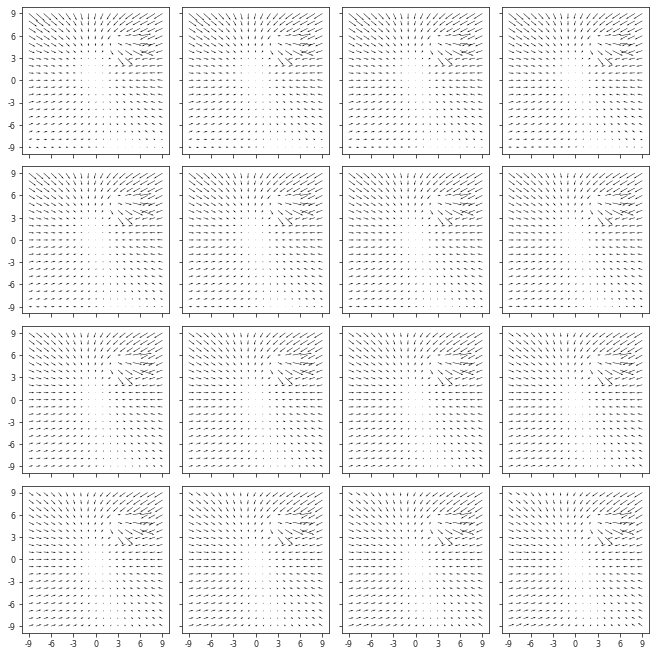

In [550]:
show_opticflow(x_new, scale=4);

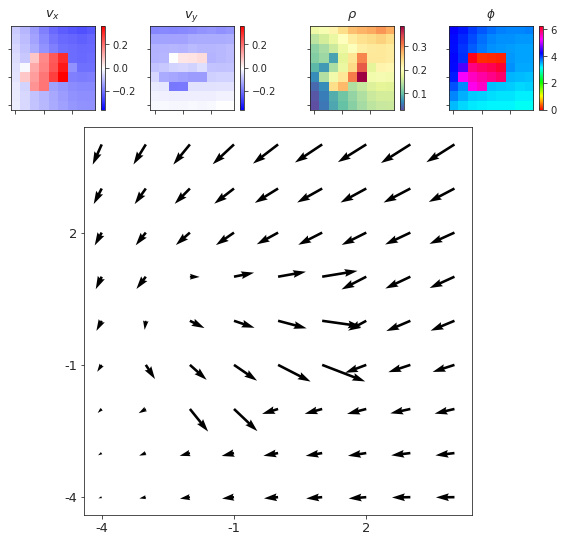

In [551]:
show_opticflow_full(x_new[0][:, 10:, 10:]);

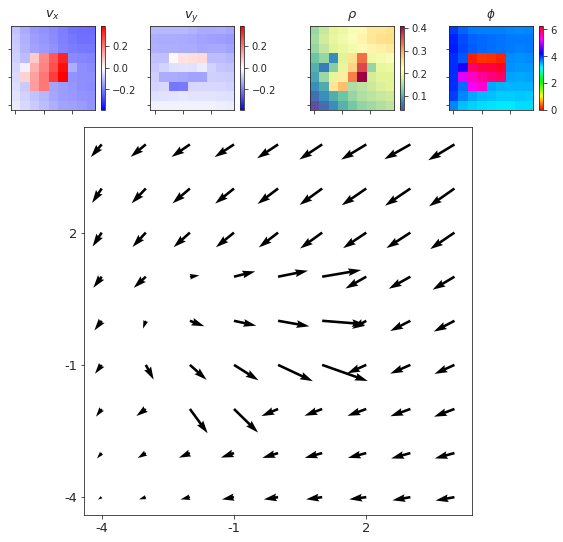

In [552]:
show_opticflow_full(x_new[-1][:, 10:, 10:]);

In [346]:
delta = 0.1
low = value - delta * (n // 2)
high = value + delta * (n // 2)

In [347]:
z_traverse = torch.linspace(low, high, n).to(device)
z_traverse = z_traverse.unsqueeze(-1).unsqueeze(-1)

In [334]:
# latents[which_group][:, which_latent] = z_traverse

In [348]:
idx = 0
s = self.prior_ftr0.unsqueeze(0)
s = s.expand(latents[idx].size(0), -1, -1, -1)
for cell in self.dec_tower:
    if isinstance(cell, CombinerDec):
        s = cell(s, self.expand[idx](latents[idx]))
        idx += 1
    else:
        s = cell(s)

if self.vanilla:
    s = self.stem_decoder(latents[idx])

for cell in self.post:
    s = cell(s)

x_sample = self.out(s)

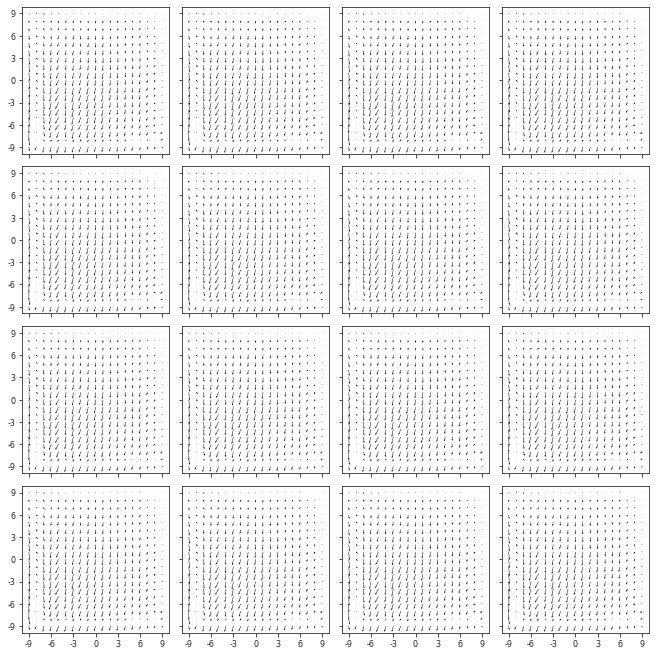

In [349]:
show_opticflow(x_sample, scale=None);

In [168]:
n = 16
t = 1.0
device = tr.device
lim = 10
z_traverse = torch.linspace(-lim, lim, n).to(device)
z_traverse = z_traverse.unsqueeze(-1).unsqueeze(-1)

In [169]:
from model.vae2d import CombinerDec
from model.distributions import Normal

In [170]:
kws = dict(temp=t, seed=self.cfg.seed, device=device)
z0_sz = [n] + self.z0_sz
mu = torch.zeros(z0_sz)
logsig = torch.zeros(z0_sz)
if device is not None:
    mu = mu.to(device)
    logsig = logsig.to(device)
dist = Normal(mu, logsig, **kws)
z = dist.sample()
if which_idx == 0:
    z[:, which_latent, ...] = z_traverse
p_all = [dist]
latents = [z]

idx = 0
s = self.prior_ftr0.unsqueeze(0)
s = s.expand(z.size(0), -1, -1, -1)
for cell in self.dec_tower:
    if isinstance(cell, CombinerDec):
        if idx > 0:
            # form prior
            param = self.dec_sampler[idx - 1](s)
            mu, logsig = torch.chunk(param, 2, dim=1)
            dist = Normal(mu, logsig, **kws)
            p_all.append(dist)
            z = dist.sample()
            if idx == which_idx: 
                z[:, which_latent, ...] = z_traverse
            latents.append(z)
        # 'combiner_dec'
        s = cell(s, self.expand[idx](z))
        idx += 1
    else:
        s = cell(s)

if self.vanilla:
    s = self.stem_decoder(z)

for cell in self.post:
    s = cell(s)

x_sample = self.out(s)
z = torch.cat(latents, dim=1).squeeze()

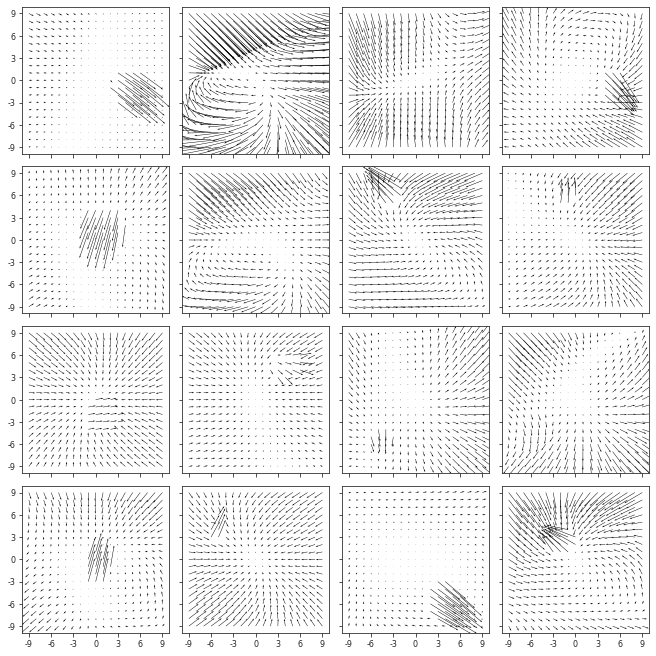

In [173]:
show_opticflow(x_sample, scale=4);